<a href="https://colab.research.google.com/github/thierrysayah/database-project/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11501568/11490434 [==============================] - 1s 0us/step


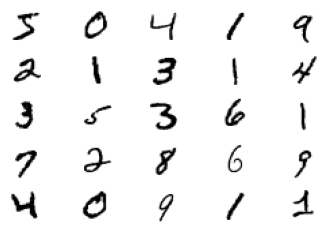

In [2]:
#load data
from keras.datasets.mnist import load_data
from matplotlib import pyplot
#load images to memory
(trainX, trainy), (testX, testy) = load_data()
# plot imgs from dataset
for i in range(25):
    #define subplot
    pyplot.subplot(5,5, 1+i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [3]:
from keras.backend import dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.layers import Reshape
from numpy.random import randn
from numpy import vstack

In [ ]:
# define standalone discriminator

def define_discriminator(in_shape = (28,28,1)):
  model = Sequential()
  model.add(Conv2D(64,(3,3),strides=(2,2), padding='same', input_shape = in_shape))
  model.add(LeakyReLU(alpha=0.02))
  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3),strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.02))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1,activation = 'sigmoid'))
  # compile model
  opt = Adam(lr = 0.0002, beta_1 =0.5)
  model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
  return model

# define model
model = define_discriminator()

model.summary()

plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = np.expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, 1))
  return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = rand(28 * 28 * n_samples)
  # reshape into a batch of grayscale images
  X = X.reshape((n_samples, 28, 28, 1))
  # generate 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y

In [6]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))


In [ ]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

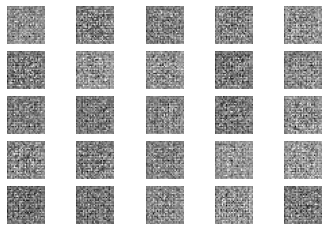

In [8]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis('off')
  # plot single image
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


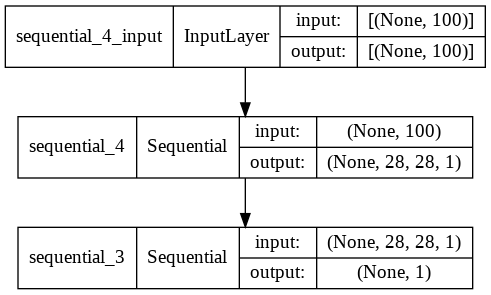

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


In [10]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
  if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [11]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)



In [1]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [12]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


>70, 141/234, d=0.681, g=0.702
>70, 142/234, d=0.681, g=0.695
>70, 143/234, d=0.681, g=0.710
>70, 144/234, d=0.680, g=0.708
>70, 145/234, d=0.691, g=0.714
>70, 146/234, d=0.692, g=0.727
>70, 147/234, d=0.679, g=0.725
>70, 148/234, d=0.683, g=0.722
>70, 149/234, d=0.687, g=0.711
>70, 150/234, d=0.683, g=0.701
>70, 151/234, d=0.689, g=0.702


KeyboardInterrupt: ignored